# Experiment

This notebook provides small experiments in the paper "Characterizing Overfitting in Kernel Ridgeless Regression Through the Eigenspectrum". 


## 0. Import Packages

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import time

# Select one of the following
#np.random.seed(int(time.time()))
np.random.seed(0)

#graphic
sns.set(style="white")
sns.set_palette("dark")
#sns.pairplot(data, kind="scatter", hue = "Class")
plt.rcParams.update({'font.size': 30})
plt.rcParams['lines.linewidth'] = 4
plt.rc('legend',fontsize=16)
plt.rc('axes', titlesize=16)
plt.rc('axes', labelsize=16)

print("Packages imported.")

Packages imported.


## 1. Gaussian Random Feature Model

We first start the experiment with Gaussian features. We assume that the input $x\sim\mathcal{N}(0,\bm{\Lambda}^{1/2})$ is Gaussian where the covariance is a diagonal matrix $\bm{\Lambda}$ with exponential or polynomial decay. Then the kernel matrix is simply $\mathbf{K}=\bm{\Psi}^\top\bm{\Lambda}\bm{\Psi}$ where $\bm{\Psi}\in\mathbb{R}^{M\times N}$ is a random matrix with i.i.d. Gaussian entries.

In [8]:
N =  10 # training size
M = 100 # kernel rank

test_size = 1000 # test size

decay_factor = 2 # 2 is quadratic decay
noise_variance = 1

def polynomial_decay_matrix(decay_factor=decay_factor, size=M):
    # Generate diagonal entries following polynomial decay
    diagonal_entries = np.array([ (i+1)**(-decay_factor) for i in range(size)])

    # Create a diagonal matrix
    decay_matrix = np.diag(diagonal_entries)

    return decay_matrix

def generate_data(N=N, M=M, if_noise=False, noise_variance = 1,true_coefficients = np.random.normal(0, 1, size=M)):
# Generate a random Gaussian matrix with non-trivial covariance
    mean = np.zeros(M)  # Mean vector
    covariance_matrix = polynomial_decay_matrix(decay_factor=decay_factor, size=M)
    input = np.random.multivariate_normal(mean, covariance_matrix, size=N)
    output = np.dot(input, true_coefficients)
    if if_noise == True:
        output += np.random.normal(0, noise_variance, size=N)
    return input, output


We are ready to compute the condition number of the kernel matrix $\mathbf{K}$ and the mean square error (MSE) of the kernel ridgeless regression. We run over 20 iterations and set the quartiles as error bars. We start by polynomial decay.

In [9]:
# compute the MSE of linear regression
num_it = 20
N_list = np.arange(10,300,10)
theta = 10 # the overparameterization ratio
mse_list=[]
mse_upper_quartile = []
mse_lower_quartile = []
cond_list = []
cond_upper_quartile = []
cond_lower_quartile = []

for N in N_list:
    M = N * theta
    true_coefficients = np.random.normal(0, 1, size=M) # determine a new random true coefficient for each N,M
    X_test, y_test = generate_data(N=test_size, M=M, if_noise=False, noise_variance = noise_variance, true_coefficients=true_coefficients)
    mse_it = []
    cond_it = []
    for it in range(num_it):
        X_train, y_train = generate_data(N=N, M=M, if_noise=True, noise_variance = noise_variance,true_coefficients=true_coefficients)
        # Compute condition number
        covariance = X_train @ X_train.T
        eigenvalues = np.linalg.eigvalsh (covariance)
        condition_num = np.max(eigenvalues)/np.min(eigenvalues)
        cond_it.append(condition_num)
        # Initialize and fit the linear regression model
        model = LinearRegression()
        model.fit(X_train, y_train)
        # Make predictions on the test set
        y_pred = model.predict(X_test)
        # Evaluate the model
        mse = mean_squared_error(y_test, y_pred)
        mse_it.append(mse)
    mse_list.append(np.percentile(mse_it, 50))
    mse_upper_quartile.append(np.percentile(mse_it, 75))
    mse_lower_quartile.append(np.percentile(mse_it, 25))
    cond_list.append(np.percentile(cond_it, 50))
    cond_upper_quartile.append(np.percentile(cond_it, 75))
    cond_lower_quartile.append(np.percentile(cond_it, 25))


First, we take a sanity check for the condition number.

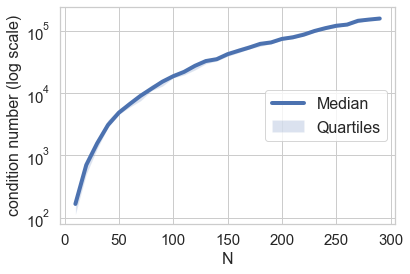

In [28]:
sns.set(style="whitegrid")
sns.lineplot(x=N_list, y=np.array(cond_list), label= "Median", linewidth = 4)
plt.fill_between(x=N_list, y1=np.array(cond_lower_quartile), y2=np.array(cond_upper_quartile), alpha=0.2, label='Quartiles')
#plt.title("ratio between empirical condition number and its asymtpotic estimate")
plt.xlabel("N", fontsize = 16)
plt.yscale("log")
plt.ylabel("condition number (log scale)", fontsize = 16)
plt.legend(loc = 'center right', fontsize = 16)
plt.xticks(fontsize = 15) 
plt.yticks(fontsize = 15) 
# Show the plot
plt.savefig('cond_num_poly_0.pdf', bbox_inches="tight")
plt.show()

Then we check for the ratio claimed in Theorem 4.1 in the paper. The line is expected to be asymptotically bounded by some constants.

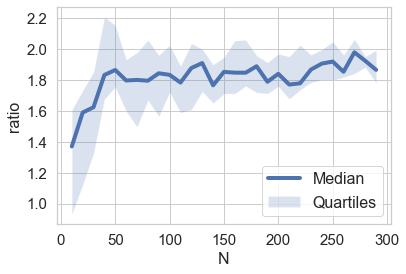

In [29]:
# plot the estimation of condition number
cond_list_estimation = np.array([(N+1)**(decay_factor) for N in N_list])
sns.set(style="whitegrid")
sns.lineplot(x=N_list, y=np.array(cond_list)/cond_list_estimation, label= "Median", linewidth = 4)
plt.fill_between(x=N_list, y1=np.array(cond_lower_quartile)/cond_list_estimation, y2=np.array(cond_upper_quartile)/cond_list_estimation, alpha=0.2, label='Quartiles')
#plt.title("ratio between empirical condition number and its asymtpotic estimate")
plt.xlabel("N", fontsize = 16)
#plt.yscale("log")
plt.ylabel("ratio", fontsize = 16)
plt.legend(loc = 'lower right', fontsize = 16)
plt.xticks(fontsize = 15) 
plt.yticks(fontsize = 15) 
# Show the plot
plt.savefig('cond_num_poly.pdf', bbox_inches="tight")
plt.show()

By Theorem 4.2, we expect tempered overfitting for polynomial decay, meaning the MSE should be asymptotically bounded by some constants.

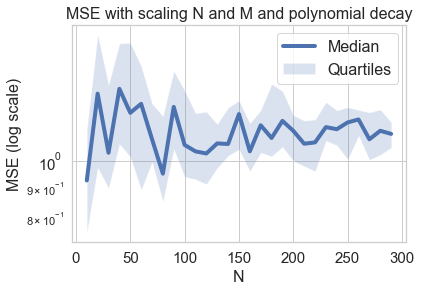

In [12]:
# plot the learning curve
sns.set(style="whitegrid")
sns.lineplot(x=N_list, y=mse_list, label= "Median",linewidth = 4)
plt.fill_between(x=N_list, y1=mse_lower_quartile, y2=mse_upper_quartile, alpha=0.2, label='Quartiles')
plt.title("MSE with scaling N and M and polynomial decay", fontsize = 16)
plt.xlabel("N", fontsize = 16)
plt.yscale("log")
plt.ylabel("MSE (log scale)", fontsize = 16)
plt.legend(fontsize = 16)
plt.xticks(fontsize = 15) 
plt.yticks(fontsize = 15) 
# Show the plot
plt.savefig('learning_curve_poly.pdf', bbox_inches="tight")
plt.show()

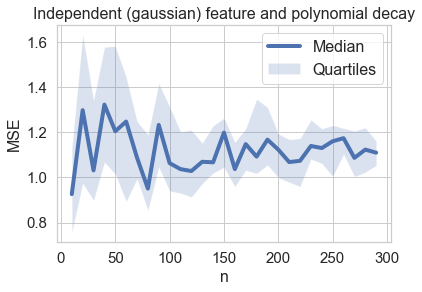

In [49]:
# plot the learning curve
sns.set(style="whitegrid")
sns.lineplot(x=N_list, y=mse_list, label= "Median",linewidth = 4)
plt.fill_between(x=N_list, y1=mse_lower_quartile, y2=mse_upper_quartile, alpha=0.2, label='Quartiles')
plt.title("Independent (gaussian) feature and polynomial decay", fontsize = 16)
plt.xlabel("n", fontsize = 16)
#plt.yscale("log")
plt.ylabel("MSE", fontsize = 16)
plt.legend(fontsize = 16)
plt.xticks(fontsize = 15) 
plt.yticks(fontsize = 15) 
# Show the plot
plt.savefig('learning_curve_poly_1.pdf', bbox_inches="tight")
plt.show()

Next, we run the same experiment for exponential decay. Note that due to its nature, the computation can be numerically unstable if the decay is too fast. We set the decay factor to be 1.1 to obtain a slower decay.

In [7]:
N =  10 # training size
M = 100 # kernel rank

test_size = 1000 # test size

decay_factor = 1.1
noise_variance = 1

def exponential_decay_matrix(decay_factor=decay_factor, size=M):
    # Generate diagonal entries following polynomial decay
    diagonal_entries = np.array([ decay_factor**(-(i+1)) for i in range(size)])

    # Create a diagonal matrix
    decay_matrix = np.diag(diagonal_entries)

    return decay_matrix

def generate_data(N = N, M = M, if_noise = False, noise_variance = 1, true_coefficients = true_coefficients):
# Generate a random Gaussian matrix with non-trivial covariance
    mean = np.zeros(M)  # Mean vector
    covariance_matrix = exponential_decay_matrix(decay_factor=decay_factor, size=M)
    input = np.random.multivariate_normal(mean, covariance_matrix, size=N)
    output = np.dot(input, true_coefficients)
    if if_noise == True:
        output += np.random.normal(0, noise_variance, size=N)
    return input, output

num_it = 20
N_list = np.arange(10,300,10)
theta = 10 # the overparameterization ratio
mse_list=[]
mse_upper_quartile = []
mse_lower_quartile = []
cond_list = []
cond_upper_quartile = []
cond_lower_quartile = []

for N in N_list:
    M = N * theta
    true_coefficients = np.random.normal(0, 1, size=M) # determine a new random true coefficient for each N,M
    X_test, y_test = generate_data(N=test_size, M=M, if_noise=False, noise_variance = noise_variance, true_coefficients=true_coefficients)
    mse_it = []
    cond_it = []
    for it in range(num_it):
        X_train, y_train = generate_data(N=N, M=M, if_noise=True, noise_variance = noise_variance,true_coefficients=true_coefficients)
        # Compute condition number
        covariance = X_train @ X_train.T
        eigenvalues = np.linalg.eigvalsh (covariance)
        condition_num = np.max(eigenvalues)/np.min(eigenvalues)
        cond_it.append(condition_num)
        # Initialize and fit the linear regression model
        model = LinearRegression()
        model.fit(X_train, y_train)
        # Make predictions on the test set
        y_pred = model.predict(X_test)
        # Evaluate the model
        mse = mean_squared_error(y_test, y_pred)
        mse_it.append(mse)
    mse_list.append(np.percentile(mse_it, 50))
    mse_upper_quartile.append(np.percentile(mse_it, 75))
    mse_lower_quartile.append(np.percentile(mse_it, 25))
    cond_list.append(np.percentile(cond_it, 50))
    cond_upper_quartile.append(np.percentile(cond_it, 75))
    cond_lower_quartile.append(np.percentile(cond_it, 25))


Again a sanity check on the condition number.

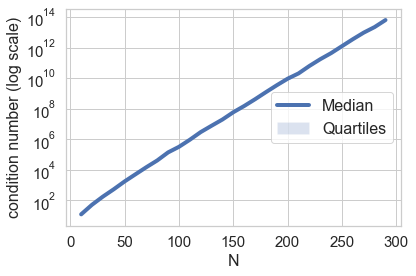

In [8]:
sns.set(style="whitegrid")
sns.lineplot(x=N_list, y=np.array(cond_list), label= "Median", linewidth = 4)
plt.fill_between(x=N_list, y1=np.array(cond_lower_quartile), y2=np.array(cond_upper_quartile), alpha=0.2, label='Quartiles')
#plt.title("ratio between empirical condition number and its asymtpotic estimate")
plt.xlabel("N", fontsize = 16)
plt.yscale("log")
plt.ylabel("condition number (log scale)", fontsize = 16)
plt.legend(loc = 'center right', fontsize = 16)
plt.xticks(fontsize = 15) 
plt.yticks(fontsize = 15) 
# Show the plot
plt.savefig('cond_num_exp_0.pdf', bbox_inches="tight")
plt.show()

Again we check for the ratio claimed in Theorem 4.1 in the paper. The line is expected to be asymptotically bounded by some constants.

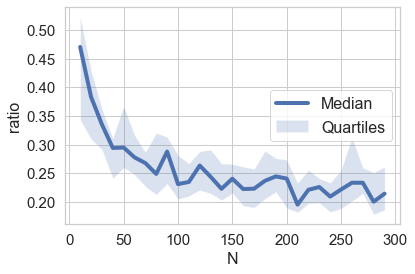

In [9]:
# plot the estimation of condition number
cond_list_estimation = np.array([N * decay_factor**(N) for N in N_list])
sns.set(style="whitegrid")
sns.lineplot(x=N_list, y=np.array(cond_list)/cond_list_estimation, label= "Median", linewidth = 4)
plt.fill_between(x=N_list, y1=np.array(cond_lower_quartile)/cond_list_estimation, y2=np.array(cond_upper_quartile)/cond_list_estimation, alpha=0.2, label='Quartiles')
#plt.title("ratio between empirical condition number and its asymtpotic estimate")
plt.xlabel("N", fontsize = 16)
#plt.yscale("log")
plt.ylabel("ratio", fontsize = 16)
plt.legend(loc = 'center right', fontsize = 16)
plt.xticks(fontsize = 15) 
plt.yticks(fontsize = 15) 
# Show the plot
plt.savefig('cond_num_exp.pdf', bbox_inches="tight")
plt.show()

By Theorem 4.3, we expect catastrophic overfitting for exponential decay, meaning the MSE should increase (at least linearly) as $N\to\infty$.

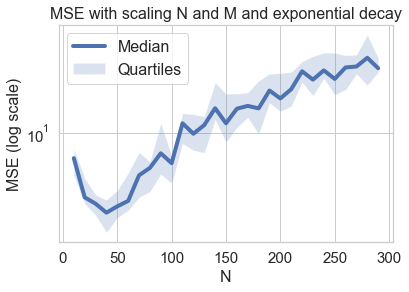

In [10]:
# plot learning curve
sns.set(style="whitegrid")

sns.lineplot(x=N_list, y=mse_list, label= "Median", linewidth = 4)
plt.fill_between(x=N_list, y1=mse_lower_quartile, y2=mse_upper_quartile, alpha=0.2, label='Quartiles')
plt.title("MSE with scaling N and M and exponential decay", fontsize = 16)
plt.xlabel("N", fontsize = 16)
plt.yscale("log")
plt.ylabel("MSE (log scale)", fontsize = 16)
plt.legend(fontsize = 16)
plt.xticks(fontsize = 15) 
plt.yticks(fontsize = 15) 
# Show the plot
plt.savefig('learning_curve_exp.pdf', bbox_inches="tight")
plt.show()

## 2. Fourier Features

The tempered and catastrophic overfittings also occur in realistic kernels. In the following, we experiments on the Fourier features with different decays.

We run linear regression on a simple target function $\tilde{f}=\cos(3x)$ on the interval $[0,\pi]$ using the features $\{\lambda_k\cos(k\cdot)\}_{k=1}^m$ for some positive $\lambda_k$.

First we choose a simple target function:

In [2]:
# Set the number of samples and capacity m of the model
num_samples = 50

# Generate synthetic dataset

# Select one of the following
#np.random.seed(int(time.time()))
np.random.seed(0)


X = np.random.uniform(0, np.pi, num_samples)
y = np.cos(3*X) + np.random.normal(0, 0.1, num_samples)

# Generate x-axis values for plotting
x_plot = np.linspace(0, np.pi, 5000)


Now we run the simulations:

In [3]:
# fit the curve for plot (e)
m = 1000  # Set the desired capacity here

# Extract features
decay_power = 2
X_features = [i**(-decay_power) * np.cos(i*X) for i in range(1, m+1)]
X_features = np.column_stack(X_features)

# Fit linear regression model
model = LinearRegression()
model.fit(X_features, y)

# Predict on the entire x-axis
x_plot_features_e = [i**(-decay_power) * np.cos(i*x_plot) for i in range(1, m+1)]
x_plot_features_e = np.column_stack(x_plot_features_e)
y_pred_plot_e = model.predict(x_plot_features_e)

# fit the curve for plot (g) exp decay
m = 1000  # Set the desired capacity here

# Extract features
decay_power = 2
X_features = [(decay_power)**(-i) * np.cos(i*X) for i in range(1, m+1)]
X_features = np.column_stack(X_features)

# Fit linear regression model
model = LinearRegression()
model.fit(X_features, y)

# Predict on the entire x-axis
x_plot_features_g = [(decay_power)**(-i) * np.cos(i*x_plot) for i in range(1, m+1)]
x_plot_features_g = np.column_stack(x_plot_features_g)
y_pred_plot_g = model.predict(x_plot_features_g)

# fit the curve for plot (z)
m = 3  # Set the desired capacity here

# Extract features
decay_power = 0
X_features = [i**(-decay_power) * np.cos(i*X) for i in range(1, m+1)]
X_features = np.column_stack(X_features)
X_reg = [1 * i**(-0.5) * np.cos(i*X) for i in range(1, 200)]
X_reg = np.column_stack(X_reg)
X_features_reg = np.concatenate((X_features,X_reg),axis = 1)

# Fit linear regression model
model = LinearRegression()
model.fit(X_features_reg, y)

# Predict on the entire x-axis
x_plot_features_z = [i**(-decay_power) * np.cos(i*x_plot) for i in range(1, m+1)]
x_plot_features_z = np.column_stack(x_plot_features_z)
x_plot_reg = [1 * i**(-0.5) * np.cos(i*x_plot) for i in range(1, 200)]
x_plot_reg = np.column_stack(x_plot_reg)
x_plot_features_z = np.concatenate((x_plot_features_z,x_plot_reg),axis = 1)

y_pred_plot_z = model.predict(x_plot_features_z)

We generate a cartoon for different overfitting.

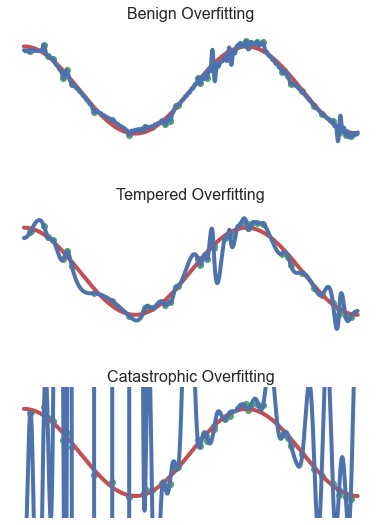

In [4]:
# Create a 1x3 grid of subplots with shared x and y axes
fig, axs = plt.subplots(3, 1, sharex=True, sharey=True, figsize = (6,8))

# Plot data in each subplot
axs[0].scatter(X, y, color='g', label='samples')
axs[0].plot(x_plot, np.cos(3 * x_plot), color='r', label='target Function')
axs[0].plot(x_plot, y_pred_plot_z, color='b', label='Learned Function')

axs[1].scatter(X, y, color='g', label='samples')
axs[1].plot(x_plot, np.cos(3 * x_plot), color='r', label='target Function')
axs[1].plot(x_plot, y_pred_plot_e, color='b', label='Learned Function')

axs[2].scatter(X, y, color='g', label='samples')
axs[2].plot(x_plot, np.cos(3 * x_plot), color='r', label='target Function')
axs[2].plot(x_plot, y_pred_plot_g, color='b', label='Learned Function')

# Set the title for each subplot (optional)
axs[0].set_title('Benign Overfitting')
axs[1].set_title('Tempered Overfitting')
axs[2].set_title('Catastrophic Overfitting')

# turn off axes
axs[0].axis('off')
axs[1].axis('off')
axs[2].axis('off')

# Set y limit
plt.ylim(-1.5,1.5)

# Adjust the layout to prevent overlapping of titles
plt.tight_layout()
plt.savefig('overfitting.pdf')  # Save the plot

# Display the plots
plt.show()



Generate horizontal plot

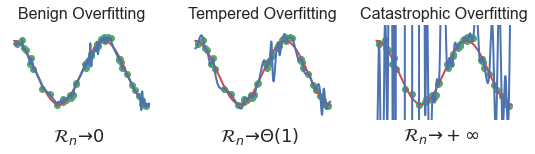

In [48]:
plt.rcParams['lines.linewidth'] = 2

# Create a 1x3 grid of subplots with shared x and y axes
fig, axs = plt.subplots(1, 3, sharex=True, sharey=True, figsize = (8,3))

# Plot data in each subplot
axs[0].scatter(X, y, color='g', label='samples')
axs[0].plot(x_plot, np.cos(3 * x_plot), color='r', label='target Function')
axs[0].plot(x_plot, y_pred_plot_z, color='b', label='Learned Function')

axs[1].scatter(X, y, color='g', label='samples')
axs[1].plot(x_plot, np.cos(3 * x_plot), color='r', label='target Function')
axs[1].plot(x_plot, y_pred_plot_e, color='b', label='Learned Function')

axs[2].scatter(X, y, color='g', label='samples')
axs[2].plot(x_plot, np.cos(3 * x_plot), color='r', label='target Function')
axs[2].plot(x_plot, y_pred_plot_g, color='b', label='Learned Function')

# Set the title for each subplot (optional)
axs[0].set_title('Benign Overfitting')
axs[1].set_title('Tempered Overfitting')
axs[2].set_title('Catastrophic Overfitting')


axs[0].text(1.5, -2, '$\mathcal{R}_n \\to 0$', horizontalalignment='center', verticalalignment='center', fontsize = 18)
axs[1].text(1.5, -2, '$\mathcal{R}_n \\to \Theta(1)$', horizontalalignment='center', verticalalignment='center', fontsize = 18)
axs[2].text(1.5, -2, '$\mathcal{R}_n \\to +\infty$', horizontalalignment='center', verticalalignment='center', fontsize = 18)

# turn off axes
axs[0].axis('off')
axs[1].axis('off')
axs[2].axis('off')



# Set y limit
plt.ylim(-1.5,1.5)

# Adjust the layout to prevent overlapping of titles
plt.tight_layout()
plt.savefig('overfitting_horizontal.pdf')  # Save the plot

# Display the plots
plt.show()

# 3. Empirical Kernel spectrum

We can further compute the spectra for realistic kernels such as Laplacian and Gaussian kernels. 

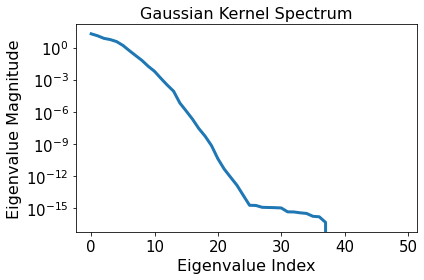

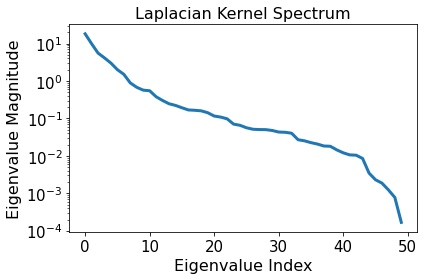

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "


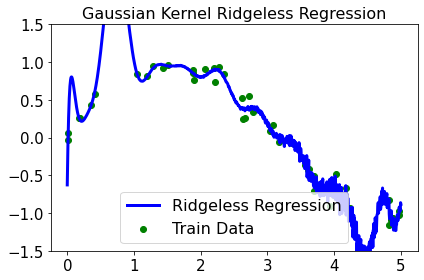

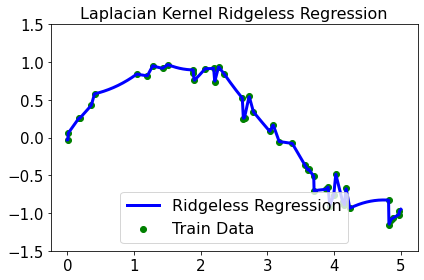

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.kernel_ridge import KernelRidge
from scipy.linalg import eigh
from sklearn.metrics.pairwise import pairwise_kernels

# Function to generate a dataset with noisy labels
def generate_dataset(n_samples=50, noise=0.1):
    X = np.sort(5 * np.random.rand(n_samples, 1), axis=0)
    y = np.sin(X).ravel() + noise * np.random.normal(size=n_samples)
    return X, y

# Function to compute and plot the spectrum of the kernel matrix
def plot_kernel_spectrum(X, kernel, title):
    K = pairwise_kernels(X, metric=kernel)
    eigenvalues, _ = eigh(K)
    sorted_eigenvalues = np.sort(eigenvalues)[::-1]

    plt.plot(sorted_eigenvalues, label=kernel.capitalize() + ' Spectrum', linewidth = 3)
    plt.title(title, fontsize = 16)
    plt.xlabel('Eigenvalue Index', fontsize = 16)
    plt.ylabel('Eigenvalue Magnitude', fontsize = 16)
    plt.yscale("log")
    plt.xticks(fontsize = 15) 
    plt.yticks(fontsize = 15) 
    #plt.legend()
    # Adjust the layout to prevent overlapping of titles
    plt.tight_layout()
    plt.savefig(kernel.capitalize() + 'kernel_spectrum.pdf')  # Save the plot
    plt.show()

# Function to perform kernel ridge regression and plot the results
def plot_kernel_ridge_regression(X_train, y_train, kernel, alpha, title):
    X_test = np.linspace(0, 5, 1000)[:, None]
    K_train = pairwise_kernels(X_train, X_train, metric=kernel)
    K_test = pairwise_kernels(X_test, X_train, metric=kernel)

    model = KernelRidge(alpha=alpha, kernel=kernel)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    plt.scatter(X_train, y_train, label='Train Data', color='g')
    plt.plot(X_test, y_pred, label='Ridgeless Regression', color='b', linewidth = 3)
    plt.title(title, fontsize = 16)
    #plt.xlabel('X')
    #plt.ylabel('y')
    plt.ylim(-1.5,1.5)
    plt.xticks(fontsize = 15) 
    plt.yticks(fontsize = 15) 
    plt.legend(loc = 'lower center', fontsize = 16)
    plt.tight_layout()
    plt.savefig(kernel.capitalize() + 'kernel_overfitting.pdf')  # Save the plot
    plt.show()

# Generate a dataset
X_train, y_train = generate_dataset()

# Plot the spectrum for Gaussian Kernel
plot_kernel_spectrum(X_train, kernel='rbf', title='Gaussian Kernel Spectrum')

# Plot the spectrum for Laplacian Kernel
plot_kernel_spectrum(X_train, kernel='laplacian', title='Laplacian Kernel Spectrum')

# Perform Kernel Ridge Regression for Gaussian Kernel
plot_kernel_ridge_regression(X_train, y_train, kernel='rbf', alpha=0.0, title='Gaussian Kernel Ridgeless Regression')

# Perform Kernel Ridge Regression for Laplacian Kernel
plot_kernel_ridge_regression(X_train, y_train, kernel='laplacian', alpha=0.0, title='Laplacian Kernel Ridgeless Regression')


# 4.  Computation of normal vector 

This experiment concerns about the independent feature Assumptions used in Lemma B.5. 
We want to compute the empirical distribution of the dot-product square $(\bm{\psi}_k^\top\mathbf{N}_k)^2$, where the feature vectors $\bm{\psi}_k=(\cos(kx_i))_{i=1}^N$ represent cosines evaluated on the training set $\{x_i\}_{i=1}^N$, and $\mathbf{N}_k$ is a unit normal vector of the hyperplane spanned by $\psi_l$ 's for $l\neq k$. 

We have a sanity check on the dot-product $\bm{\psi}_k^\top\mathbf{N}_k$ for different frequency $k$.

In [24]:
import numpy as np

# Step 1: Generate N random points on a circle
N = 300

# Note that random point and linspace produce big difference!!
theta = np.random.uniform(-np.pi, np.pi, N)
#theta = np.linspace(-np.pi, np.pi, N)

# Step 2: Apply the cosine functions
M = 10  # Number of cosine functions
cosine_vectors = [np.cos(k * theta) for k in range(1, M + 1)]

# Step 3-5: Compute unit normal vectors and dot products
for k in range(1, M + 1):
    # Step 3: Form the matrix representing the hyperplane H_k
    H_k_matrix = np.delete(cosine_vectors, k - 1, axis=0)

    # Step 4: Compute a unit normal vector N_k for H_k using QR decomposition (Gram-Schmidt)
    _, N_k = np.linalg.qr(H_k_matrix)

    # Step 5: Compute the dot product of v_k and N_k
    dot_product_vk_Nk = np.dot(cosine_vectors[k - 1], N_k[-1,:])

    # Print the result
    print(f"For k = {k}, Dot product of v_k and N_k: {dot_product_vk_Nk}")


For k = 1, Dot product of v_k and N_k: 24.20287346400993
For k = 2, Dot product of v_k and N_k: -20.33457226541318
For k = 3, Dot product of v_k and N_k: -14.888892682279257
For k = 4, Dot product of v_k and N_k: -6.111572407903341
For k = 5, Dot product of v_k and N_k: 6.772392788344894
For k = 6, Dot product of v_k and N_k: 13.432751246277338
For k = 7, Dot product of v_k and N_k: 16.242905023716265
For k = 8, Dot product of v_k and N_k: 17.954080735329374
For k = 9, Dot product of v_k and N_k: 18.92783449069917
For k = 10, Dot product of v_k and N_k: -18.986985875460793


Then we run over 100 iterations of training set and compute the dot-prodcut square $(\bm{\psi}_k^\top\mathbf{N}_k)^2$ for different frequency $k$.

In [25]:
# Step 1: Generate N random points on a circle
N = 100

# Note that random point and linspace produce big difference!!

#theta = np.linspace(-np.pi, np.pi, N)

# Step 2: Apply the cosine functions
M = 10  # Number of cosine functions

# Set number of iterations, initialize an array to store dot products for each k and each draw
num_it = 100
dot_products = np.zeros((M, num_it))

for it in range(num_it):
    theta = np.random.uniform(-np.pi, np.pi, N)
    #theta = np.linspace(-np.pi, np.pi, N)
    cosine_vectors = [np.cos(k * theta) for k in range(1, M + 1)]
    # Step 3-5: Compute unit normal vectors and dot products
    for k in range(1, M + 1):
        # Step 3: Form the matrix representing the hyperplane H_k
        H_k_matrix = np.delete(cosine_vectors, k - 1, axis=0)

        # Step 4: Compute a unit normal vector N_k for H_k using QR decomposition (Gram-Schmidt)
        _, N_k = np.linalg.qr(H_k_matrix)

        # Step 5: Compute the dot product of v_k and N_k
        dot_product_vk_Nk = np.dot(cosine_vectors[k - 1], N_k[-1,:])
        dot_products[k-1,it] = dot_product_vk_Nk


We observe a heavy-tailed distribution for each frequency $k$, indicating the anticoncentration property of $(\bm{\psi}_k^\top\mathbf{N}_k)^2$ in a dependent features setting.

Mean of distribution for k = 1 is  28.104786581589273
Mean of distribution for k = 5 is  24.169768899091864
Mean of distribution for k = 9 is  25.68909702889182


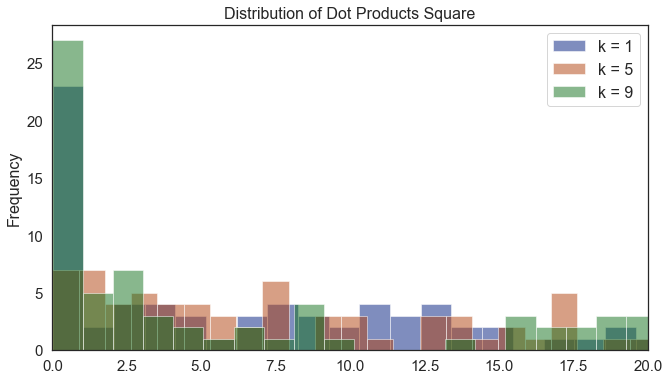

In [25]:
k_values = [1,5,9]
# Plot the distributions
plt.figure(figsize=(10, 6))
for k in k_values:
    plt.hist(np.square(dot_products[k, :]), bins=200, alpha=0.5, label=f'k = {k}')
    print(f'Mean of distribution for k = {k} is ', np.mean(np.square(dot_products[k, :])))
plt.title('Distribution of Dot Products Square', fontsize = 16)
#plt.xlabel('Dot Product Square $(\bm{\psi}_k^\top\mathbf{N}_k)^2$')
plt.xlim(0,20)
plt.ylabel('Frequency', fontsize = 16)
plt.legend(fontsize = 16)
plt.xticks(fontsize = 15) 
plt.yticks(fontsize = 15) 
plt.tight_layout()
plt.savefig('dot_product_square.pdf')
plt.show()